In [50]:
%matplotlib inline
import numpy as np
from pathlib import Path
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import tqdm
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from torch.autograd import Variable
from preprocessing import *
from model import *
from tensorboardX import SummaryWriter

In [51]:
class Average(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def find_latest_model(dir):
    model_paths, epochs = [], []
    for path in Path(dir).glob('*.pt'):
        if 'epoch' not in path.stem:
            continue
        model_paths.append(path)
        parts = path.stem.split('_')
        epochs.append(int(parts[-1]))

    if len(epochs) > 0:
        epochs = np.array(epochs)
        max_idx = np.argmax(epochs)
        return model_paths[max_idx]
    else:
        return None

In [ ]:
class MetricsMethod(object):
    def __init__(self) -> None:
        pass
    def PA(self):
        pass
    def CPA(self):
        pass
    def MPA(self):
        pass
    def Dice(self):
        pass
    def IOU(self):
        pass
    def MIOU(self):
        pass
    def mAP(self):
        pass

In [103]:
def GraphVisualization(dataset: MyDataset, model=None, col=5, target_dir: str="./"):
    rows = ['Images', 'Ground\nTruth\nMasks', 'Ground\nTruth\nFusions',
            'Prediction\nMasks', 'Prediction\nFusions', 'Prediction V.S.\nGround Truth']
    if model is None:
        fig, axes = plt.subplots(nrows=3, ncols=col, figsize=(10,10))

        for i in range(3):
            axes[i][0].annotate(rows[i], xy=(0, 0.5), xytext=(-30,60),
                                xycoords='axes points', textcoords='offset points',
                                size='large', ha='center', va='center')

        for i in range(5):
            filename = Path(dataset.imgPaths[i]).stem
            data = dataset.__getitem__(i)
            mask = np.array(data[1]).squeeze()
            invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                                 std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                            transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                                 std = [ 1., 1., 1. ])])
            img = invTrans(data[0])
            img = np.array(img).transpose(1,2,0)

            axes[0][i].set_title(filename, {'fontsize': 8})
            axes[0][i].get_xaxis().set_visible(False)
            axes[0][i].get_yaxis().set_visible(False)
            axes[0][i].imshow(img)
            axes[1][i].get_xaxis().set_visible(False)
            axes[1][i].get_yaxis().set_visible(False)
            axes[1][i].imshow(mask, cmap='magma')
            axes[2][i].get_xaxis().set_visible(False)
            axes[2][i].get_yaxis().set_visible(False)
            axes[2][i].imshow(img)
            axes[2][i].imshow(mask, cmap='twilight', alpha=0.6)

        fig.tight_layout(h_pad=-25)
        plt.savefig(os.path.join(target_dir, 'sample.png'), dpi=500)
        plt.show()
    else:
        pass

In [53]:
def validate(model, val_loader, criterion):
    losses = Average()
    model.eval()
    with torch.no_grad():

        for i, (input, target) in enumerate(val_loader):
            input_var = Variable(input).to(device)
            target_var = Variable(target).to(device)

            output = model(input_var)
            output = torch.argmax(output, dim=1, keepdim=True).float()
            loss = criterion(output, target_var)

            losses.update(loss.item(), input_var.size(0))

    return losses.avg

In [105]:
def train(config, train_loader, model, criterion, optimizer, scheduler, validation):
    with SummaryWriter(log_dir='runs/segmentation_1v1') as writer:

        latest_model_path = find_latest_model(model_dir)
        best_model_path = os.path.join(*[model_dir, 'model_best.pt'])

        if latest_model_path is not None:
            state = torch.load(latest_model_path)
            epoch = state['epoch']
            model.load_state_dict(state['model'])
            epoch = epoch

            assert Path(best_model_path).exists() == True, f'best model path {best_model_path} does not exist'
            best_state = torch.load(latest_model_path)
            min_val_los = best_state['valid_loss']

            print(f'Restored model at epoch {epoch}. Min validation loss : {min_val_los}')
            epoch += 1
            print(f'Started training model from epoch {epoch}')
        else:
            print('Started training model from epoch 0')
            epoch = 0
            min_val_los = 9999

        valid_losses = []
        for epoch in range(epoch, config['n_epoch'] + 1):

            tq = tqdm.tqdm(total=(len(train_loader) * config['batch_size']))
            tq.set_description(f'Epoch {epoch}')

            running_losses = Average()

            model.train()
            for i, (input_img, masks_true) in enumerate(train_loader):
                input_img  = Variable(input_img, requires_grad=True).to(device)
                masks_true = Variable(masks_true, requires_grad=True).to(device)

                masks_pred = model(input_img)

                masks_pred = torch.argmax(masks_pred, dim=1, keepdim=True).float()
                masks_probs_flat = masks_pred.view(-1)
                masks_true_flat  = masks_true.view(-1)

                loss = criterion(masks_probs_flat, masks_true_flat)
                running_losses.update(loss)

                tq.set_postfix(loss='{:.5f}'.format(running_losses.avg))
                tq.update(config['batch_size'])

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            scheduler.step()
            valid_loss = validation(model, valid_loader, criterion)
            valid_losses.append(valid_loss)
            print(f'valid_loss = {valid_loss:.5f}')
            tq.close()

            writer.add_scalar('data/valid_loss', valid_loss, epoch)
            writer.add_scalar('data/train_loss', running_losses.avg, epoch)

            epoch_model_path = os.path.join(*[model_dir, f'model_epoch_{epoch}.pt'])
            torch.save({
                'model': model.state_dict(),
                'epoch': epoch,
                'valid_loss': valid_loss,
                'train_loss': running_losses.avg
            }, epoch_model_path)

            if valid_loss < min_val_los:
                min_val_los = valid_loss
                torch.save({
                    'model': model.state_dict(),
                    'epoch': epoch,
                    'valid_loss': valid_loss,
                    'train_loss': running_losses.avg
                }, best_model_path)
        
        writer.add_hparams( hparam_dict=config,
                            metric_dict={'min_val_loss': min_val_los},
                            name='table')

In [97]:
config = {  'n_epoch': 10,
            'lr': 0.001,
            'momentum': 0.9,
            'print_freq': 20,
            'weight_decay': 1e-4,
            'batch_size': 2,
            'num_workers': 0}

model_dir = "./model"
orig_img_dir = "./dataset/images"
orig_msk_dir = "./dataset/masks"
save_json = "./dataset/dataset.json"
save_samples = "./dataset/samples"

if save_samples != '':
    os.makedirs(save_samples, exist_ok=True)
    for sample in Path(save_samples).glob('*.*'):
        os.remove(str(sample))

if not os.path.exists(save_json):
    obtain_path(img_dir=orig_img_dir, mask_dir=orig_msk_dir, target_path=str(save_json))

os.makedirs(model_dir, exist_ok=True)

In [56]:
gpu_id = 0

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(gpu_id)
device = torch.device("cuda:{}".format(str(gpu_id)) if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 3060 Laptop GPU


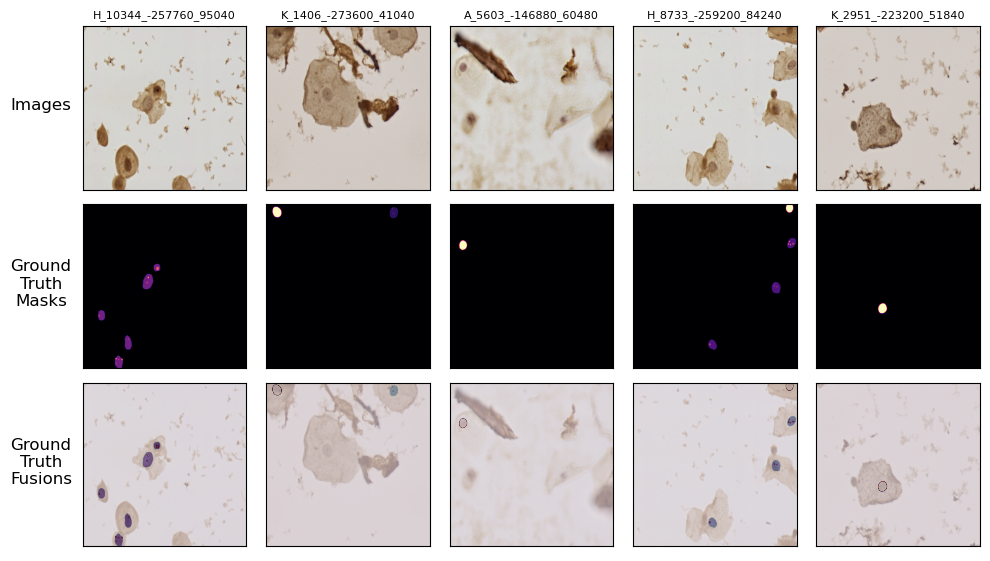

In [104]:
channel_means = [0.485, 0.456, 0.406]
channel_stds  = [0.229, 0.224, 0.225]

dataset = divide_dataset(save_json, [0.7,0.1,0.2])

train_tfms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(channel_means, channel_stds)])
val_tfms = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(channel_means, channel_stds)])
test_tfms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(channel_means, channel_stds)])
mask_tfms = transforms.Compose([transforms.ToTensor()])

train_set = MyDataset(dataset, train_tfms, mask_tfms, 'train')
valid_set = MyDataset(dataset, val_tfms, mask_tfms, 'valid')
test_set = MyDataset(dataset, test_tfms, mask_tfms, 'test')

train_loader = DataLoader(  train_set,
                            config['batch_size'],
                            shuffle=True,
                            pin_memory=torch.cuda.is_available(),
                            num_workers=config['num_workers'])
valid_loader = DataLoader(  valid_set,
                            config['batch_size'],
                            shuffle=True,
                            pin_memory=torch.cuda.is_available(),
                            num_workers=config['num_workers'])
test_loader = DataLoader(   test_set,
                            config['batch_size'],
                            shuffle=True,
                            pin_memory=torch.cuda.is_available(),
                            num_workers=config['num_workers'])

GraphVisualization(test_set, model=None, col=5, target_dir=save_samples)

In [9]:
model = ResUNet(Block=ResBlock, DecBlock=DecBlock)
optimizer = torch.optim.Adam(model.parameters(), config['lr'],
                            weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, 0.1)
criterion = nn.BCEWithLogitsLoss().to(device)

model.to(device)

train(config, train_loader, model, criterion, optimizer, scheduler, validate)

Started training model from epoch 0


Epoch 0: 100%|██████████| 20/20 [00:33<00:00,  1.67s/it, loss=4.44146]

	valid_loss = 5.08239



Epoch 1: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s, loss=4.43324]

	valid_loss = 4.76066



Epoch 2: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s, loss=4.44296]

	valid_loss = 4.62155



Epoch 3: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s, loss=4.42166]

	valid_loss = 4.54424



Epoch 4: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s, loss=4.43255]

	valid_loss = 4.50854



Epoch 5: 100%|██████████| 20/20 [00:05<00:00,  3.37it/s, loss=4.43498]

	valid_loss = 4.50069



Epoch 6: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s, loss=4.43781]

	valid_loss = 4.48936



Epoch 7: 100%|██████████| 20/20 [00:05<00:00,  3.39it/s, loss=4.44968]

	valid_loss = 4.48352



Epoch 8: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s, loss=4.42605]

	valid_loss = 4.47126



Epoch 9: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s, loss=4.43156]

	valid_loss = 4.46245



Epoch 10: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s, loss=4.42026]

	valid_loss = 4.47030
